In [190]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np

# For Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# SK learn packages

from sklearn.metrics import make_scorer
from sklearn import datasets, svm, cross_validation, tree, preprocessing, metrics
import sklearn.ensemble as ske
import tensorflow as tf
from sklearn.metrics import mean_squared_error
import math
from math import sqrt
import time


In [191]:
test_data = "/Users/ashish/Documents/kaggle/MercariPriceSuggestionChallenge/test.tsv"
train_data = "/Users/ashish/Documents/kaggle/MercariPriceSuggestionChallenge/train.tsv"

In [192]:
# 1. Extract 3 category related features 
def cat_split(row):
    try:
        text = row
        txt1, txt2, txt3 = text.split('/')
        return txt1, txt2, txt3
    except:
        return "empty", "empty", "empty"


In [193]:
test_df = pd.read_csv(test_data, sep='\t')

str(len(test_df))



'693359'

In [198]:
test_df[test_df.isnull().any(axis=1)]

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...
5,5,iPhone 6 Plus or 6s Plus Vodka pink case,1,"Electronics/Cell Phones & Accessories/Cases, C...",NaN,1,One Absolut Vodka in Pink for iPhone 6 Plus an...
7,7,Rose Gold Stainless Steel Quartz Watch,1,Women/Women's Accessories/Watches,NaN,1,Brand new Price firm No trades Box included wi...
9,9,Rose Brushes and Silicone Sponge,1,Beauty/Tools & Accessories/Makeup Brushes & Tools,NaN,1,All new. 12 pcs makeup brushes and one Silicon...
10,10,BNWT Coach coated canvas wristlet,1,Handmade/Bags and Purses/Wristlet,NaN,0,Authentic. Retail [rm]. Bramble rose. BNWT. Co...
11,11,"""John Carpenters Halloween""",2,Electronics/Media/DVD,NaN,0,--NO FREE SHIPPING-- •No Scratches• ◆All PRICE...
14,14,Versace Eros 200 ml 6.7 fl oz for men,1,Beauty/Fragrance/Men,NaN,1,Brand new authentic money back guarantee Free ...


In [199]:
test_df.brand_name.unique()

array([nan, 'Coach', 'Vintage', ..., 'Astroglide', 'Hi-Tec', 'PediaCare'], dtype=object)

In [154]:
#read data 
train_df = pd.read_csv(train_data, sep='\t').sample(1000)
test_df = pd.read_csv(test_data, sep='\t').sample(1000)

#explode category column into subcategories
train_df["cat_1"], train_df["cat_2"], train_df["cat_3"] = zip(*train_df.category_name.apply(lambda val: cat_split(val)))
test_df["cat_1"], test_df["cat_2"], test_df["cat_3"] = zip(*test_df.category_name.apply(lambda val: cat_split(val)))

#fill NAN values with No Brand where brand is missing
train_df.brand_name = train_df.brand_name.fillna("nobrand")

train_df.cat_1 = train_df.cat_1.fillna("nocategory")
train_df.cat_2 = train_df.cat_2.fillna("nocategory")
train_df.cat_3 = train_df.cat_3.fillna("nocategory")

#compute log10 of price

train_df["log_price"]=np.log10(train_df["price"]+1)


# making dictionaries for different categories 
keys = train_df.cat_1.unique().tolist() + test_df.cat_1.unique().tolist()
keys = list(set(keys))
values = list(range(keys.__len__()))
cat1_dict = dict(zip(keys, values))

keys2 = train_df.cat_2.unique().tolist() + test_df.cat_2.unique().tolist()
keys2 = list(set(keys2))
values2 = list(range(keys2.__len__()))
cat2_dict = dict(zip(keys2, values2))

keys3 = train_df.cat_3.unique().tolist() + test_df.cat_3.unique().tolist()
keys3 = list(set(keys3))
values3 = list(range(keys3.__len__()))
cat3_dict = dict(zip(keys3, values3))

# making dictionaries for different brand names 
keys4 = train_df.brand_name.unique().tolist() + test_df.brand_name.unique().tolist()
keys4 = list(set(keys4))
values4 = list(range(keys4.__len__()))
brand_dict = dict(zip(keys4, values4))


train_df['cat_1'] = train_df['cat_1'].map(cat1_dict)
train_df['cat_2'] = train_df['cat_2'].map(cat2_dict)
train_df['cat_3'] = train_df['cat_3'].map(cat3_dict)
train_df['brand_name'] = train_df['brand_name'].map(brand_dict)



In [178]:
train_df.columns
train_df[['train_id', 'name']]


round(np.expm1(train_df.log_price).astype("float"),3)

87912       1.177
103237     11.810
1103723     3.184
981632      2.509
553479      3.741
1471914     3.047
622755      2.903
31725       2.334
806883      3.184
698185      2.752
226145      3.565
496794      1.833
1230594     3.116
607380      1.942
2430        3.184
1236377     2.752
1459248     1.833
858522      2.509
1356131     3.047
406427      6.421
739984      2.752
1404107     2.146
249350      2.423
643243      1.177
745703      1.833
1406271     2.334
1022131     3.798
10651       3.116
692365      1.012
924264      1.328
            ...  
859972      2.509
254936      1.177
1350893     3.741
518299      3.565
392791      4.017
688400      1.718
1133031     2.242
127556      9.092
347560      2.752
945754      2.146
1212264     1.833
779437      1.718
106184      2.976
1375834     3.909
566697      1.833
929572     12.866
1011501     2.146
1245462     2.509
952464      3.184
89384       1.718
714079      3.380
70299       2.673
1084772     3.184
277116      2.673
1279927   

In [34]:
train_df[["name","brand_name", "item_condition_id", "shipping", "item_description", "cat_1", "cat_2","cat_3", "log_price"]].head()

,name,brand_name,item_condition_id,shipping,item_description,cat_1,cat_2,cat_3,log_price
868708,Nike Presto (GS) Kids Wolf Grey Sz 7Y,54,1,1,"Nike Presto GS New, Never Worn, In Original Bo...",1,19,95,1.806180
108899,Lands' End Swim Shorts,177,2,0,"Black, size 10 swim shorts. Built in undies. W...",4,2,160,1.113943
352241,Planet wise wet bags,45,2,1,Washed but never used Planet wise wet bags Clo...,1,26,142,1.176091
1185455,PS4 - Kontrol Freek Thumbsticks,45,1,0,"These are PS4 Thumbsticks, that go over the Th...",9,62,81,1.230449
637068,LuLaRoe Gray Microstripe Irma XS,45,2,1,Gray with black microstripes. New with tags un...,4,31,123,1.491362


In [24]:
#encode categorical values
le = preprocessing.LabelEncoder()
train_df["cat_cat_1"] = le.fit_transform(train_df.cat_1)
train_df["cat_cat_2"] = le.fit_transform(train_df.cat_2)
train_df["cat_cat_3"] = le.fit_transform(train_df.cat_3)
train_df["cat_brand_name"] = le.fit_transform(train_df.brand_name)

In [126]:
# Perform the necessary imports
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

# Create a TruncatedSVD instance: svd
svd = TruncatedSVD(n_components=100)

# Create a KMeans instance: kmeans
kmeans = KMeans(n_clusters=7)

# Create a pipeline: pipeline
pipeline = make_pipeline(svd)

In [144]:
#text feature extraction from name
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english',  vocabulary=None, norm='l2')
X_train = vectorizer.fit_transform(train_df.name)


name_reduction=svd.fit_transform(X_train)
name_columns = ["name_"+str(reduce_name[0].tolist().index(i)) for i in reduce_name[0].tolist()]

#print(name_columns)

print(pd.DataFrame (data=name_reduction, columns = name_columns ).head())

#return "name_"+i for i in vectorizer.get_feature_names()
train_df= pd.concat([train_df, pd.DataFrame (data=reduce_name, index=train_df.index) ], axis=1)

#train_df= pd.concat([train_df, pd.DataFrame (data=X_train.tocoo(copy=False).toarray(), columns=name_columns,  index=train_df.index) ], axis=1)
#print(train_df.columns)

     name_0        name_1    name_2    name_3    name_4    name_5    name_6  \
0  0.033107  1.330056e-03  0.029578  0.143336  0.060531  0.004064  0.133882   
1  0.024844  5.502744e-03  0.010240  0.113533  0.039822 -0.009380  0.201435   
2  0.000005 -6.864927e-08  0.000009  0.000041  0.000022  0.000014 -0.000019   
3  0.000766 -1.478412e-04  0.001019  0.001570  0.001619  0.001943 -0.004833   
4  0.080538  1.733227e-02  0.332833 -0.058156 -0.032499 -0.013794  0.008541   

     name_7    name_8    name_9    ...      name_90   name_91   name_92  \
0 -0.042132 -0.019380 -0.017167    ...    -0.010874  0.020628  0.024835   
1 -0.153050 -0.089639  0.030421    ...    -0.000418  0.071645  0.113490   
2  0.000056  0.000078 -0.000086    ...    -0.004452  0.006122 -0.000068   
3 -0.001901  0.009618 -0.000081    ...    -0.005332 -0.008926 -0.001682   
4  0.033353 -0.028415  0.020485    ...     0.089416  0.039326  0.017587   

    name_93   name_94   name_95   name_96   name_97   name_98   name_99  


In [123]:
x=svd.fit_transform(X_train)

# Calculate the cluster labels: labels
#labels = pipeline.predict(X_train)
print(x.shape)
print(labels.size)

# Create a DataFrame aligning labels and titles: df
df = pd.DataFrame({'label': labels, 'article': range(0,1000)})

# Display df sorted by cluster label
print(df.sort_values('label').tail())

print(df['label'].unique())


df['label'].value_counts(ascending = False)

(1000, 100)
1000
     article  label
971      971      6
722      722      6
538      538      6
496      496      6
0          0      6
[6 1 0 4 2 5 3]


1    810
2     50
0     46
6     31
5     25
4     20
3     18
Name: label, dtype: int64

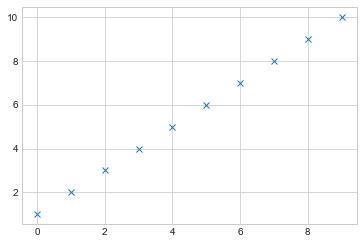

In [150]:
import numpy as np
import matplotlib.pyplot as pp
val = 0. # this is the value where you want the data to appear on the y-axis.
ar = np.arange(10) # just as an example array
pp.plot(ar, ar+1, 'x')
pp.show()

[ 0.06063696  0.05842599  0.04970872  0.04344233  0.03723615]
0.249450138285


AttributeError: 'TruncatedSVD' object has no attribute 'singular_values_'

In [116]:
index = list(df[df['label']==5]['article'])
index


[26,
 69,
 131,
 199,
 217,
 254,
 290,
 336,
 338,
 346,
 374,
 403,
 406,
 443,
 481,
 564,
 573,
 609,
 678,
 689,
 704,
 823,
 858,
 883,
 931]

In [96]:
train_df.iloc[index]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cat_1,cat_2,...,name_york,name_yoshis,name_younique,name_youth,name_yugioh,name_zara,name_zebra,name_zink,name_zip,name_zippered
209070,209070,Pink pullover hoodie (2),3,Women/Sweaters/Hooded,178,15.0,0,I HAVE A SMALL AND X SMALL [rm] each,4,46,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
160443,160443,Gel Pink Fishtail with Yellow Accents,1,Women/Jewelry/Bracelets,45,5.0,1,No description yet,4,33,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
916892,916892,(2) VS Pink!,3,Women/Tops & Blouses/T-Shirts,162,24.0,0,Burgandy sz XSmall Marled Gray sz Small - NWOT...,4,31,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
384203,384203,VS Pink S Full Zip and Gym Pants,1,Women/Sweaters/Full Zip,178,77.0,0,Brand new The top don't have price tag only th...,4,46,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.508024,0.0
534578,534578,Large PINK hoodie!,2,Women/Sweaters/Hooded,45,22.0,0,Beautiful grey bling hoodie! Super cute detail...,4,46,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
969826,969826,2 Pack LED Lights Pink,1,Home/Home Décor/Lamps& Accessories,45,12.0,1,No description yet,2,80,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
494119,494119,VS New York NYC Exclusive Bag Trio,1,Women/Women's Handbags/Cosmetic Bags,162,20.0,0,▶▶PLEASE READ ALL BEFORE MESSAGING◀◀ ❌❌NO HOLD...,4,50,...,0.491235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
893053,893053,VS pink tank top,2,"Women/Tops & Blouses/Tank, Cami",178,19.0,0,Perfect condition,4,31,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
47148,47148,Georgia bulldogs pink ladies sunglasses,1,Sports & Outdoors/Fan Shop/NCAA,45,15.0,0,100 percent UV protection,6,9,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
525891,525891,New VS Weekender Bag,1,Women/Women's Handbags/Totes & Shoppers,162,20.0,1,New VS Weekender Bag Brand New In packaging Vi...,4,50,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [85]:
training_set= train_df.drop(["train_id","item_description", "name", "category_name", "brand_name"], axis=1).copy()
training_set.head()

,item_condition_id,price,shipping,cat_1,cat_2,cat_3,log_price,0100m,08,10,...,name_york,name_yoshis,name_younique,name_youth,name_yugioh,name_zara,name_zebra,name_zink,name_zip,name_zippered
868708,1,63.0,1,1,19,95,1.806180,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108899,2,12.0,0,4,2,160,1.113943,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
352241,2,14.0,1,1,26,142,1.176091,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1185455,1,16.0,0,9,62,81,1.230449,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
637068,2,30.0,1,4,31,123,1.491362,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
print (10**1.0413926851582251)

11.000000000000002


In [53]:
np.log10(11)

1.0413926851582251

In [64]:


sentenceData = pd.DataFrame(data=[
    (0.0, "Hi I heard about Spark"),
    (0.0, "I wish Java could use case classes"),
    (1.0, "Logistic regression models are neat")
], columns=["label", "sentence"])

tokenizer = Tokenizer(inputCol="sentence", outputCol="words")
wordsData = tokenizer.transform(sentenceData)

hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=20)
featurizedData = hashingTF.transform(wordsData)
# alternatively, CountVectorizer can also be used to get term frequency vectors

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

rescaledData.select("label", "features").show()

NameError: name 'Tokenizer' is not defined